# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [30]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

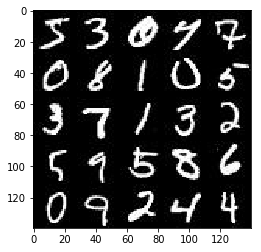

In [31]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

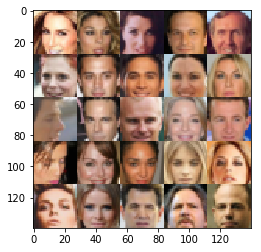

In [32]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [118]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [177]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [178]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input layer is 28x28x3 
        x1 = tf.layers.conv2d(images, 16, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x16 now
        
        x2 = tf.layers.conv2d(relu1, 64, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x64 now
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256 now
        
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [179]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse=not is_train):
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 7x7x128 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 14x14x16 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [180]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*(1 - 0.1)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [196]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)   
        
    with tf.control_dependencies(update_ops):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [182]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [200]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, input_learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_num in range(epoch_count):
            steps = 0
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                # Generate noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, input_learning_rate: learning_rate})

                if steps % 50 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_num+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 500 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.4101... Generator Loss: 9.9094
Epoch 1/2... Discriminator Loss: 0.4996... Generator Loss: 3.0403
Epoch 1/2... Discriminator Loss: 0.7503... Generator Loss: 1.9205
Epoch 1/2... Discriminator Loss: 0.7287... Generator Loss: 1.8608
Epoch 1/2... Discriminator Loss: 0.6818... Generator Loss: 2.8607
Epoch 1/2... Discriminator Loss: 0.6329... Generator Loss: 2.5933
Epoch 1/2... Discriminator Loss: 0.7274... Generator Loss: 1.8516
Epoch 1/2... Discriminator Loss: 1.3932... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.1634... Generator Loss: 0.8626
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 1.9472


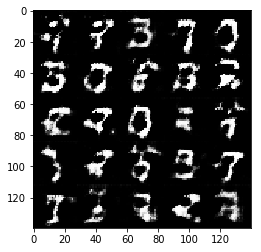

Epoch 1/2... Discriminator Loss: 1.2109... Generator Loss: 3.5387
Epoch 1/2... Discriminator Loss: 0.8399... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 0.8885... Generator Loss: 1.7239
Epoch 1/2... Discriminator Loss: 1.1922... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.2865... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 0.9417... Generator Loss: 1.4839
Epoch 1/2... Discriminator Loss: 1.4431... Generator Loss: 0.5266
Epoch 1/2... Discriminator Loss: 1.1492... Generator Loss: 0.7837
Epoch 1/2... Discriminator Loss: 1.2468... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 1.0666... Generator Loss: 2.3874


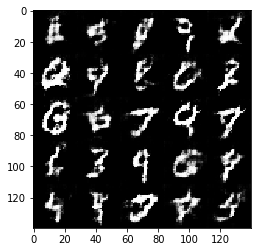

Epoch 1/2... Discriminator Loss: 0.9247... Generator Loss: 1.2908
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.8644
Epoch 1/2... Discriminator Loss: 1.2345... Generator Loss: 0.7423
Epoch 1/2... Discriminator Loss: 1.1123... Generator Loss: 0.8332
Epoch 1/2... Discriminator Loss: 0.9311... Generator Loss: 1.5895
Epoch 1/2... Discriminator Loss: 1.3151... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.0949... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.1617... Generator Loss: 0.7084
Epoch 1/2... Discriminator Loss: 1.2697... Generator Loss: 0.7666
Epoch 1/2... Discriminator Loss: 1.0621... Generator Loss: 0.8561


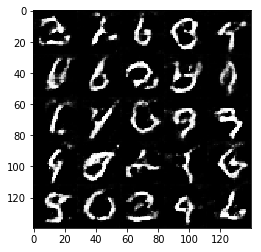

Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 0.8041
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.7905
Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.5647
Epoch 1/2... Discriminator Loss: 1.0760... Generator Loss: 0.8007
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.5895
Epoch 1/2... Discriminator Loss: 1.2525... Generator Loss: 0.6816
Epoch 1/2... Discriminator Loss: 1.0719... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.2182... Generator Loss: 0.8697
Epoch 1/2... Discriminator Loss: 0.9959... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 0.7838... Generator Loss: 1.3384


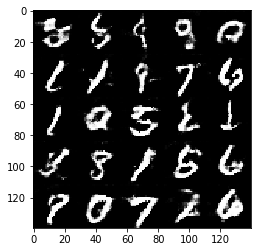

Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.5325
Epoch 1/2... Discriminator Loss: 0.8446... Generator Loss: 1.3590
Epoch 1/2... Discriminator Loss: 0.7739... Generator Loss: 1.3117
Epoch 1/2... Discriminator Loss: 0.9965... Generator Loss: 1.6137
Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 1.2366
Epoch 1/2... Discriminator Loss: 1.1893... Generator Loss: 0.7268
Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.0210
Epoch 1/2... Discriminator Loss: 1.0519... Generator Loss: 1.8014
Epoch 1/2... Discriminator Loss: 0.8675... Generator Loss: 1.1229
Epoch 1/2... Discriminator Loss: 0.8154... Generator Loss: 1.2992


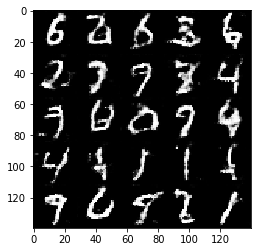

Epoch 1/2... Discriminator Loss: 1.0816... Generator Loss: 1.1183
Epoch 1/2... Discriminator Loss: 0.9480... Generator Loss: 1.1097
Epoch 1/2... Discriminator Loss: 0.8668... Generator Loss: 1.0548
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 2.2338
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 0.7485
Epoch 1/2... Discriminator Loss: 1.9844... Generator Loss: 0.2995
Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 0.7524
Epoch 1/2... Discriminator Loss: 0.8936... Generator Loss: 1.1103
Epoch 1/2... Discriminator Loss: 1.2926... Generator Loss: 0.7428
Epoch 1/2... Discriminator Loss: 1.2568... Generator Loss: 0.6173


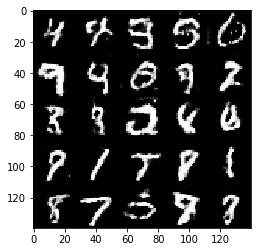

Epoch 1/2... Discriminator Loss: 1.1014... Generator Loss: 1.3497
Epoch 1/2... Discriminator Loss: 1.1200... Generator Loss: 0.8164
Epoch 1/2... Discriminator Loss: 1.1068... Generator Loss: 0.7135
Epoch 1/2... Discriminator Loss: 1.0019... Generator Loss: 1.2208
Epoch 1/2... Discriminator Loss: 1.2091... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 1.7294
Epoch 1/2... Discriminator Loss: 0.7078... Generator Loss: 1.3778
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.2113
Epoch 1/2... Discriminator Loss: 0.8414... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 0.7753... Generator Loss: 1.3832


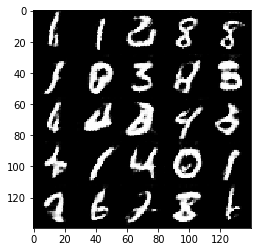

Epoch 1/2... Discriminator Loss: 0.9837... Generator Loss: 0.8175
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 1.8408
Epoch 1/2... Discriminator Loss: 1.0248... Generator Loss: 1.1878
Epoch 1/2... Discriminator Loss: 1.3303... Generator Loss: 0.6595
Epoch 1/2... Discriminator Loss: 0.7140... Generator Loss: 1.5283
Epoch 2/2... Discriminator Loss: 0.8594... Generator Loss: 1.3833
Epoch 2/2... Discriminator Loss: 0.8393... Generator Loss: 1.2642
Epoch 2/2... Discriminator Loss: 0.7189... Generator Loss: 1.4682
Epoch 2/2... Discriminator Loss: 0.5593... Generator Loss: 2.1441
Epoch 2/2... Discriminator Loss: 0.8856... Generator Loss: 1.0500
Epoch 2/2... Discriminator Loss: 0.8936... Generator Loss: 1.8890
Epoch 2/2... Discriminator Loss: 0.8981... Generator Loss: 1.2357
Epoch 2/2... Discriminator Loss: 0.7868... Generator Loss: 1.9154
Epoch 2/2... Discriminator Loss: 0.7206... Generator Loss: 1.4621
Epoch 2/2... Discriminator Loss: 1.3290... Generator Loss: 0.5885


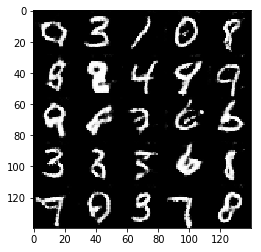

Epoch 2/2... Discriminator Loss: 0.9237... Generator Loss: 1.2027
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.4784
Epoch 2/2... Discriminator Loss: 1.7235... Generator Loss: 0.3849
Epoch 2/2... Discriminator Loss: 0.6967... Generator Loss: 1.7760
Epoch 2/2... Discriminator Loss: 1.0712... Generator Loss: 0.8386
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 1.2015
Epoch 2/2... Discriminator Loss: 1.5457... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 0.9260... Generator Loss: 0.9861
Epoch 2/2... Discriminator Loss: 0.7020... Generator Loss: 2.0591
Epoch 2/2... Discriminator Loss: 1.2498... Generator Loss: 0.6607


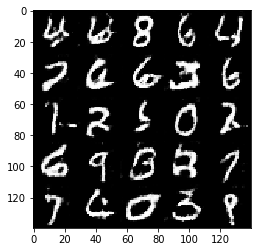

Epoch 2/2... Discriminator Loss: 0.6870... Generator Loss: 1.3230
Epoch 2/2... Discriminator Loss: 1.9812... Generator Loss: 0.3861
Epoch 2/2... Discriminator Loss: 0.9075... Generator Loss: 1.0278
Epoch 2/2... Discriminator Loss: 0.5803... Generator Loss: 2.3043
Epoch 2/2... Discriminator Loss: 0.8096... Generator Loss: 1.2364
Epoch 2/2... Discriminator Loss: 1.0432... Generator Loss: 0.9193
Epoch 2/2... Discriminator Loss: 0.7860... Generator Loss: 1.4130
Epoch 2/2... Discriminator Loss: 0.8444... Generator Loss: 1.2725
Epoch 2/2... Discriminator Loss: 0.6312... Generator Loss: 1.6730
Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 1.0395


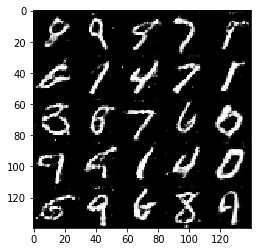

Epoch 2/2... Discriminator Loss: 1.1407... Generator Loss: 1.2243
Epoch 2/2... Discriminator Loss: 0.7093... Generator Loss: 1.6114
Epoch 2/2... Discriminator Loss: 1.5648... Generator Loss: 0.4780
Epoch 2/2... Discriminator Loss: 0.9612... Generator Loss: 0.9282
Epoch 2/2... Discriminator Loss: 0.8905... Generator Loss: 1.1522
Epoch 2/2... Discriminator Loss: 0.8977... Generator Loss: 1.1454
Epoch 2/2... Discriminator Loss: 0.6891... Generator Loss: 1.8394
Epoch 2/2... Discriminator Loss: 0.7788... Generator Loss: 2.2174
Epoch 2/2... Discriminator Loss: 0.8377... Generator Loss: 1.3835
Epoch 2/2... Discriminator Loss: 0.8570... Generator Loss: 1.1775


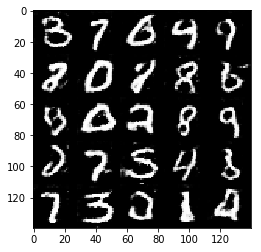

Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 0.9450
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 2.9447
Epoch 2/2... Discriminator Loss: 0.6794... Generator Loss: 1.5942
Epoch 2/2... Discriminator Loss: 0.5648... Generator Loss: 2.0434
Epoch 2/2... Discriminator Loss: 0.5473... Generator Loss: 2.6491
Epoch 2/2... Discriminator Loss: 0.9441... Generator Loss: 0.9091
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.2676
Epoch 2/2... Discriminator Loss: 0.6527... Generator Loss: 2.5425
Epoch 2/2... Discriminator Loss: 0.8987... Generator Loss: 0.9518
Epoch 2/2... Discriminator Loss: 0.6515... Generator Loss: 1.5868


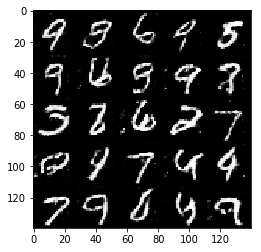

Epoch 2/2... Discriminator Loss: 1.4036... Generator Loss: 0.7790
Epoch 2/2... Discriminator Loss: 0.9134... Generator Loss: 1.0435
Epoch 2/2... Discriminator Loss: 0.5781... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.5859... Generator Loss: 1.9417
Epoch 2/2... Discriminator Loss: 1.1528... Generator Loss: 0.7334
Epoch 2/2... Discriminator Loss: 1.0524... Generator Loss: 0.8607
Epoch 2/2... Discriminator Loss: 2.1320... Generator Loss: 0.3089
Epoch 2/2... Discriminator Loss: 0.6519... Generator Loss: 2.1375
Epoch 2/2... Discriminator Loss: 1.0642... Generator Loss: 2.4409
Epoch 2/2... Discriminator Loss: 0.6023... Generator Loss: 1.9924


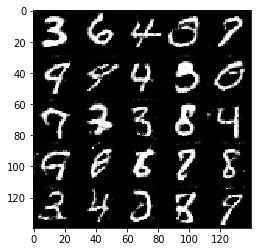

Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 1.5665
Epoch 2/2... Discriminator Loss: 1.0670... Generator Loss: 0.8397
Epoch 2/2... Discriminator Loss: 0.8644... Generator Loss: 1.3882
Epoch 2/2... Discriminator Loss: 0.7543... Generator Loss: 1.2820
Epoch 2/2... Discriminator Loss: 0.8615... Generator Loss: 1.1587
Epoch 2/2... Discriminator Loss: 0.7538... Generator Loss: 1.2748
Epoch 2/2... Discriminator Loss: 0.7493... Generator Loss: 1.3321
Epoch 2/2... Discriminator Loss: 0.7694... Generator Loss: 1.3168
Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.5531
Epoch 2/2... Discriminator Loss: 0.7784... Generator Loss: 1.3985


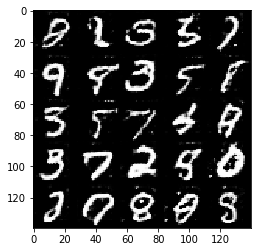

Epoch 2/2... Discriminator Loss: 0.6884... Generator Loss: 1.4124
Epoch 2/2... Discriminator Loss: 0.8133... Generator Loss: 1.1682
Epoch 2/2... Discriminator Loss: 1.6250... Generator Loss: 1.6666
Epoch 2/2... Discriminator Loss: 1.2301... Generator Loss: 0.6301
Epoch 2/2... Discriminator Loss: 0.6218... Generator Loss: 1.8723


In [205]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.7379... Generator Loss: 12.2969
Epoch 1/1... Discriminator Loss: 0.6888... Generator Loss: 1.4948
Epoch 1/1... Discriminator Loss: 0.8773... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 3.1048... Generator Loss: 5.0715
Epoch 1/1... Discriminator Loss: 2.2398... Generator Loss: 0.2865
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.4414
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.9684
Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.0315
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.4603... Generator Loss: 0.7405


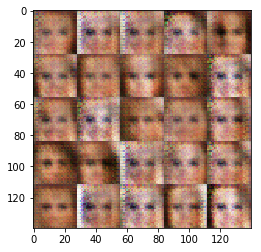

Epoch 1/1... Discriminator Loss: 1.6102... Generator Loss: 0.5016
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 1.0832
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 1.0222
Epoch 1/1... Discriminator Loss: 1.4604... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 1.0807
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.9424
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.9381
Epoch 1/1... Discriminator Loss: 1.3023... Generator Loss: 1.0213
Epoch 1/1... Discriminator Loss: 1.6011... Generator Loss: 0.7147


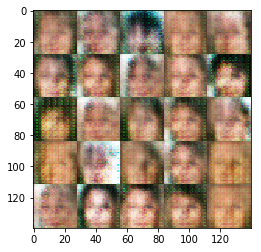

Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.9153
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.0017... Generator Loss: 1.3072
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 1.1531... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.8642
Epoch 1/1... Discriminator Loss: 1.3066... Generator Loss: 0.7455
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.1508
Epoch 1/1... Discriminator Loss: 1.4354... Generator Loss: 0.5216


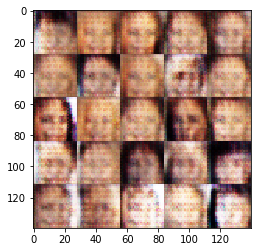

Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.8167
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6182
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 1.2415
Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.8925
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 1.0513
Epoch 1/1... Discriminator Loss: 1.2523... Generator Loss: 1.0329
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9124


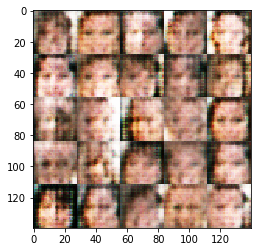

Epoch 1/1... Discriminator Loss: 1.3142... Generator Loss: 1.0273
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.8571
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 1.2690
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 0.9498
Epoch 1/1... Discriminator Loss: 1.0267... Generator Loss: 1.5352
Epoch 1/1... Discriminator Loss: 1.4438... Generator Loss: 0.8138
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 0.8905
Epoch 1/1... Discriminator Loss: 1.2949... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5957
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.0300


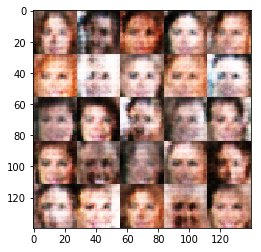

Epoch 1/1... Discriminator Loss: 1.3824... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.0358... Generator Loss: 1.2816
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.0569
Epoch 1/1... Discriminator Loss: 1.1620... Generator Loss: 0.8506
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.8425
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.8261
Epoch 1/1... Discriminator Loss: 1.5734... Generator Loss: 0.5357
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8317


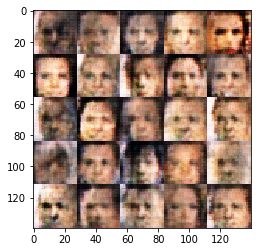

Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.8635
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6448
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.9627
Epoch 1/1... Discriminator Loss: 1.3403... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.2844... Generator Loss: 0.8915
Epoch 1/1... Discriminator Loss: 1.2039... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2728... Generator Loss: 1.0865


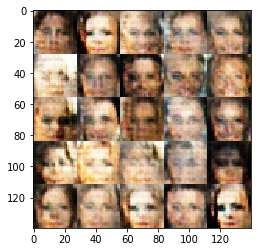

Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.8739
Epoch 1/1... Discriminator Loss: 1.2446... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.5558
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.8477
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9495
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.8485
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.2328


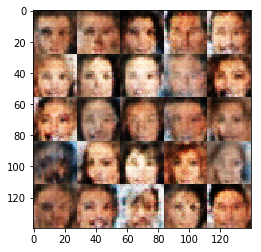

Epoch 1/1... Discriminator Loss: 1.0789... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.2288... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5152
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.7646
Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.3003... Generator Loss: 0.9432
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.9674
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.6201


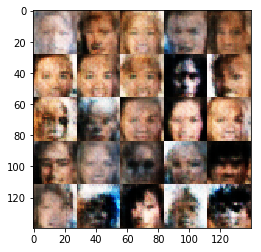

Epoch 1/1... Discriminator Loss: 1.2951... Generator Loss: 0.9633
Epoch 1/1... Discriminator Loss: 1.1300... Generator Loss: 1.1315
Epoch 1/1... Discriminator Loss: 1.2160... Generator Loss: 0.8588
Epoch 1/1... Discriminator Loss: 1.2997... Generator Loss: 0.6846
Epoch 1/1... Discriminator Loss: 1.2203... Generator Loss: 1.1236
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.9411
Epoch 1/1... Discriminator Loss: 1.2113... Generator Loss: 0.9174
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8624
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.7699


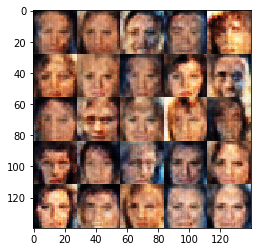

Epoch 1/1... Discriminator Loss: 1.1996... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.2431... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.3843... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9033
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8271
Epoch 1/1... Discriminator Loss: 1.0868... Generator Loss: 0.9062
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.7935


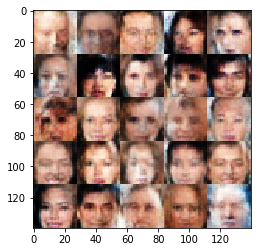

Epoch 1/1... Discriminator Loss: 1.3190... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.7873
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.7251
Epoch 1/1... Discriminator Loss: 1.4863... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7743
Epoch 1/1... Discriminator Loss: 1.2276... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.2106... Generator Loss: 0.8932
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7003
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6968


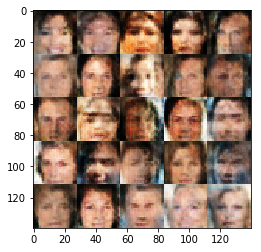

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.6729
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.2564... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.2205... Generator Loss: 0.9695
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.0432
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.0867... Generator Loss: 1.0548


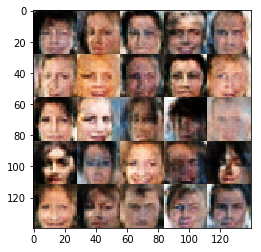

Epoch 1/1... Discriminator Loss: 1.3809... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.2036... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3505... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7924
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.8543
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.7631


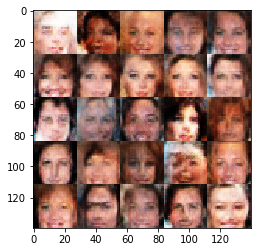

Epoch 1/1... Discriminator Loss: 1.1248... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.9085
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2624... Generator Loss: 0.7373
Epoch 1/1... Discriminator Loss: 1.1213... Generator Loss: 1.0379
Epoch 1/1... Discriminator Loss: 1.2193... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4282... Generator Loss: 0.5729


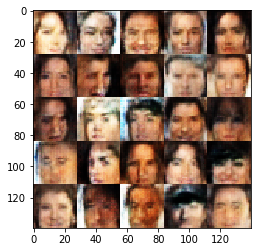

Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.9292
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.9685
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.4892
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7075
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.2625... Generator Loss: 0.9821
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6920


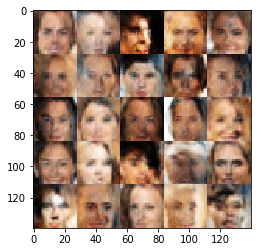

Epoch 1/1... Discriminator Loss: 1.0113... Generator Loss: 1.0545
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6081
Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.4475
Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.2198... Generator Loss: 0.8695
Epoch 1/1... Discriminator Loss: 1.1980... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 1.1268
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.7285
Epoch 1/1... Discriminator Loss: 1.2445... Generator Loss: 0.8263


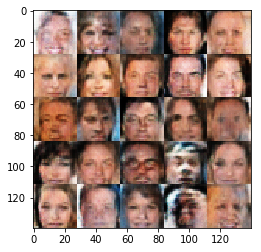

Epoch 1/1... Discriminator Loss: 1.2128... Generator Loss: 0.8898
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2348... Generator Loss: 0.8643
Epoch 1/1... Discriminator Loss: 1.1821... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.2785... Generator Loss: 0.6342


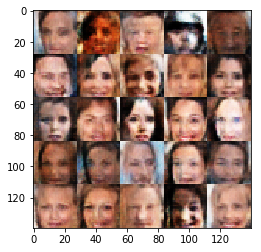

Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.2051... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.2421... Generator Loss: 0.7564
Epoch 1/1... Discriminator Loss: 1.1753... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.9660
Epoch 1/1... Discriminator Loss: 1.3681... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.1860... Generator Loss: 0.9308


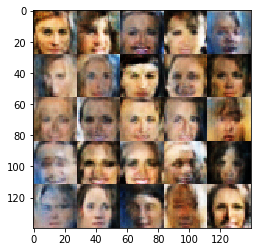

Epoch 1/1... Discriminator Loss: 1.3295... Generator Loss: 0.8615
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 0.8244
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.0839... Generator Loss: 0.8913
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.2904... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 0.9904


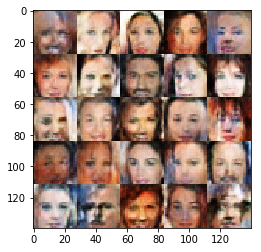

Epoch 1/1... Discriminator Loss: 1.1841... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.3896... Generator Loss: 0.5594
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6838
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6596
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7184
Epoch 1/1... Discriminator Loss: 1.2826... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.9760


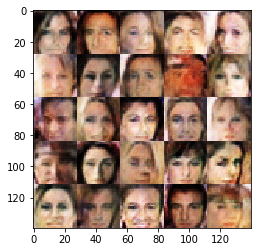

Epoch 1/1... Discriminator Loss: 1.3504... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.2896... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2393... Generator Loss: 1.2858
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.1362
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.7975
Epoch 1/1... Discriminator Loss: 1.5085... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1995... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.6621
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.7269


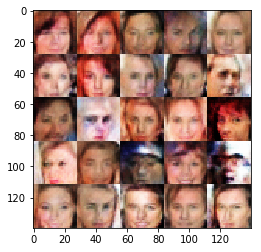

Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.8379
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.2244... Generator Loss: 0.9120
Epoch 1/1... Discriminator Loss: 1.3157... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.2724... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.0652... Generator Loss: 0.8862
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.8133


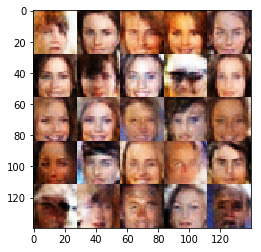

Epoch 1/1... Discriminator Loss: 1.2150... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7875
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.8115
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.8247
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8159
Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.7381
Epoch 1/1... Discriminator Loss: 1.3243... Generator Loss: 0.8395
Epoch 1/1... Discriminator Loss: 1.2725... Generator Loss: 0.7648


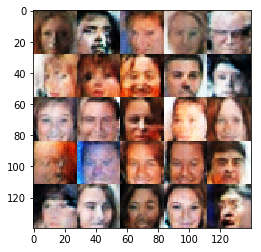

Epoch 1/1... Discriminator Loss: 1.2906... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.5361... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.7731
Epoch 1/1... Discriminator Loss: 1.2862... Generator Loss: 0.9123
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7637
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.8416


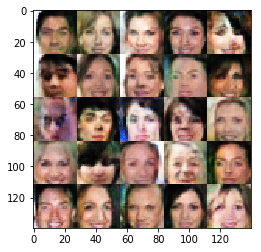

Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.7935


In [204]:
batch_size = 16
z_dim = 100
learning_rate = 0.001
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.